In [1]:
## Montar google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Importa las librerías necesarias
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [3]:
!pip install openpyxl


In [4]:
# Cargar el archivo desde Google Drive
import pandas as pd

# Especifica la ruta completa del archivo en tu Google Drive
file_path = '/content/drive/MyDrive/MachineLearning/TRAIN/GPT/grouped_trainytrial.xlsx'


# Cargar el archivo Excel en un DataFrame
df = pd.read_excel(file_path)



**Random Forest con definicion de hiperparametros**



Se utilizan los mejores hiperparametros encontrados y un listado variable de caracteristicas

In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline


# Los mejores hiperparámetros encontrados
best_params = {
    'randomforestclassifier__max_depth': 12,
    'randomforestclassifier__max_features': 'sqrt',
    'randomforestclassifier__min_samples_leaf': 1,
    'randomforestclassifier__min_samples_split':5,
    'randomforestclassifier__n_estimators': 500
}



pipeline = Pipeline([
    ('classifier', RandomForestClassifier(
         max_depth=best_params['randomforestclassifier__max_depth'],
        max_features=best_params['randomforestclassifier__max_features'],
        min_samples_leaf=best_params['randomforestclassifier__min_samples_leaf'],
        min_samples_split=best_params['randomforestclassifier__min_samples_split'],
        n_estimators=best_params['randomforestclassifier__n_estimators'],
        random_state=42,
        class_weight='balanced'   # Ajuste automático de los pesos de las clases

    ))
])





Definicion de caracteristicas


In [12]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Codificar la columna 'sentiment' en valores numéricos
label_encoder_sentiment = LabelEncoder()
df['sentiment_numeric'] = label_encoder_sentiment.fit_transform(df['sentiment'])


# Seleccionar características específicas
columnas_seleccionadas = [
   'POS','NEU','NEG',
   'alegria','tristeza' ,'miedo', 'disgusto', 'enojo', 'sorpresa',
   #'toxicity',
   'yo', 'me', 'mi','mí',
   'num_palabras_largas',
   'falta de motivacion',  'aislamiento social',  'pensamientos suicidas',

]



# Normalizar solo las columnas numéricas específicas
scaler = MinMaxScaler()
cols_to_normalize = [
    'num_palabras_mayusculas', 'num_palabras_largas',
    'negaciones','num_signos_puntuacion',
]



# Verificar que las columnas a normalizar existan en el DataFrame antes de normalizar
cols_to_normalize = [col for col in cols_to_normalize if col in df.columns]
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

# Seleccionar las características
X = df[columnas_seleccionadas].copy()

# Codificar las etiquetas de la columna 'label'
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])  # 0, 1 y 2 deben estar en esta columna

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)




Entrenamiento del modelo

In [13]:

# Entrenar el modelo

pipeline.fit(X_train, y_train)

# Hacer predicciones
y_pred = pipeline.predict(X_test)

# Calcular métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
conf_matrix = confusion_matrix(y_test, y_pred)

# Mostrar métricas
print(f'Accuracy on test set: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

# Mostrar predicciones y etiquetas verdaderas
predicciones_df = pd.DataFrame({
    'Etiqueta Verdadera': (y_test),
    'Predicción': (y_pred)
})

print('\nPredicciones y Etiquetas Verdaderas:')
print(predicciones_df)

Accuracy on test set: 0.7945
Precision: 0.7945
Recall: 0.7945
F1 Score: 0.7944
Confusion Matrix:
[[64 10  2]
 [11 37  3]
 [ 1  3 15]]

Predicciones y Etiquetas Verdaderas:
     Etiqueta Verdadera  Predicción
0                     0           0
1                     0           0
2                     1           1
3                     1           1
4                     0           0
..                  ...         ...
141                   0           0
142                   0           1
143                   1           1
144                   0           0
145                   1           1

[146 rows x 2 columns]


**Busqueda de hiperparametros**
Con validacion cruzada

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score

# Clasificador
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Espacio de búsqueda reducido
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [12, 20, None],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Definición de las métricas
scoring = {
    'accuracy': 'accuracy',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'f1_weighted': 'f1_weighted'
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1_weighted',  # El modelo final se ajusta usando esta métrica
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Entrenamiento
grid_search.fit(X_train, y_train)

# Resultados
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor puntuación F1 ponderada:", grid_search.best_score_)

# Métricas de la mejor combinación
results_df = pd.DataFrame(grid_search.cv_results_)
display(results_df[['mean_test_accuracy', 'mean_test_precision_weighted', 'mean_test_recall_weighted', 'mean_test_f1_weighted', 'params']].sort_values(by='mean_test_f1_weighted', ascending=False).head())


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores hiperparámetros: {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Mejor puntuación F1 ponderada: 0.7293778837868261


,mean_test_accuracy,mean_test_precision_weighted,mean_test_recall_weighted,mean_test_f1_weighted,params
5,0.734548,0.741769,0.734548,0.729378,"{'max_depth': 12, 'max_features': 'sqrt', 'min..."
1,0.734416,0.743481,0.734416,0.729068,"{'max_depth': 12, 'max_features': 'sqrt', 'min..."
17,0.731607,0.739114,0.731607,0.726223,"{'max_depth': 20, 'max_features': 'sqrt', 'min..."
29,0.731607,0.739114,0.731607,0.726223,"{'max_depth': None, 'max_features': 'sqrt', 'm..."
25,0.731519,0.740541,0.731519,0.725890,"{'max_depth': None, 'max_features': 'sqrt', 'm..."


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Lista de combinaciones propuestas
combinaciones = [
    {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100},   # Caso 1
    {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100},   # Caso 2
    {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100},   # Caso 3
    {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300},   # Caso 4
    {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}  # Caso 5
]

# Evaluación de cada combinación
for i, params in enumerate(combinaciones, start=1):
    print(f"🔍 Evaluando combinación #{i}: {params}")

    # Entrenamiento del modelo
    model = RandomForestClassifier(
        max_depth=params['max_depth'],
        min_samples_leaf=params['min_samples_leaf'],
        min_samples_split=params['min_samples_split'],
        n_estimators=params['n_estimators'],
        max_features='sqrt',
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"📊 Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print("-" * 60)


🔍 Evaluando combinación #1: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
📊 Accuracy: 0.8014 | Precision: 0.8019 | Recall: 0.8014 | F1: 0.8001
------------------------------------------------------------
🔍 Evaluando combinación #2: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
📊 Accuracy: 0.7877 | Precision: 0.7863 | Recall: 0.7877 | F1: 0.7868
------------------------------------------------------------
🔍 Evaluando combinación #3: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
📊 Accuracy: 0.8082 | Precision: 0.8084 | Recall: 0.8082 | F1: 0.8067
------------------------------------------------------------
🔍 Evaluando combinación #4: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
📊 Accuracy: 0.7877 | Precision: 0.7862 | Recall: 0.7877 | F1: 0.7865
------------------------------------------------------------
🔍 Evaluando combinación 

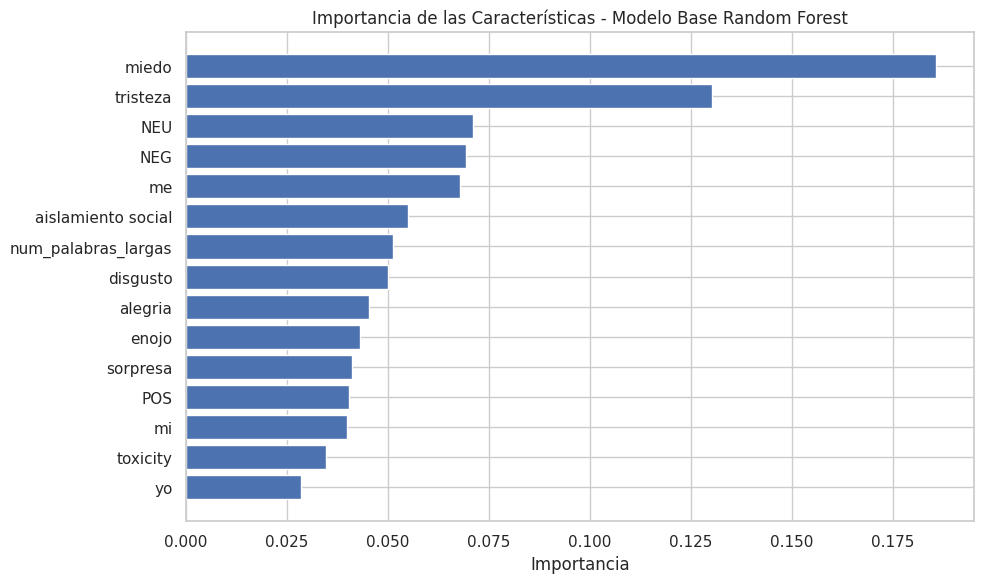

In [ ]:
# Obtener la importancia de cada característica
importancias = model.feature_importances_
features = X_train.columns

# Crear un DataFrame con los resultados
importancia_df = pd.DataFrame({
    'Feature': features,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

# Mostrar las 15 características más importantes
top_features = importancia_df.head(15)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importancia'])
plt.xlabel('Importancia')
plt.title('Importancia de las Características - Modelo Base Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()